#### **Genre Classification**

In [2]:
import torch

if torch.cuda.is_available():
    print(f"CUDA is available!")
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"Current CUDA device: #{torch.cuda.current_device()}")
else:
    print("CUDA is not available. Using CPU.")

CUDA is available!
Number of CUDA devices: 1
Using GPU: NVIDIA GeForce RTX 5070
Current CUDA device: #0


**GridSearchCV for Random Forest Classifier Model**

Fitting 5 folds for each of 64 candidates, totalling 320 fits

✅ Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

=== Classification Report ===
              precision    recall  f1-score   support

 Avant-Garde       0.54      0.40      0.46      1880
  Electronic       0.51      0.88      0.65      4346
Experimental       0.56      0.15      0.23      1327
        Folk       0.61      0.41      0.49       797
     Hip-Hop       0.76      0.25      0.38       842
         Pop       0.58      0.18      0.28      1239
        Rock       0.58      0.56      0.57      1416

    accuracy                           0.54     11847
   macro avg       0.59      0.41      0.44     11847
weighted avg       0.56      0.54      0.49     11847



<Figure size 1000x800 with 0 Axes>

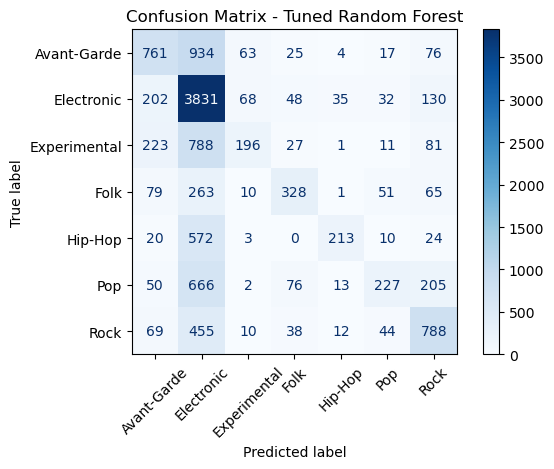

In [4]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load dataset
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
file_path = os.path.join(base_dir, "data", "processed", "final.csv")
df = pd.read_csv(file_path)

# Split into features and labels
X = df.drop(columns=['track_id', 'primary_genre'])
y = df['primary_genre']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Initialize Random Forest and GridSearchCV
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best model from GridSearchCV
best_rf = grid_search.best_estimator_
print(f"\n✅ Best Parameters: {grid_search.best_params_}")

# Predict and evaluate
y_pred = best_rf.predict(X_test)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=best_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_rf.classes_)

# Plot
plt.figure(figsize=(10, 8))
disp.plot(xticks_rotation=45, cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Tuned Random Forest")
plt.tight_layout()
plt.show()

**Random Forest Classifier Model**

=== Classification Report ===
              precision    recall  f1-score   support

 Avant-Garde       0.54      0.40      0.46      1880
  Electronic       0.51      0.88      0.65      4346
Experimental       0.56      0.15      0.23      1327
        Folk       0.61      0.41      0.49       797
     Hip-Hop       0.76      0.25      0.38       842
         Pop       0.58      0.18      0.28      1239
        Rock       0.58      0.56      0.57      1416

    accuracy                           0.54     11847
   macro avg       0.59      0.41      0.44     11847
weighted avg       0.56      0.54      0.49     11847



<Figure size 1000x800 with 0 Axes>

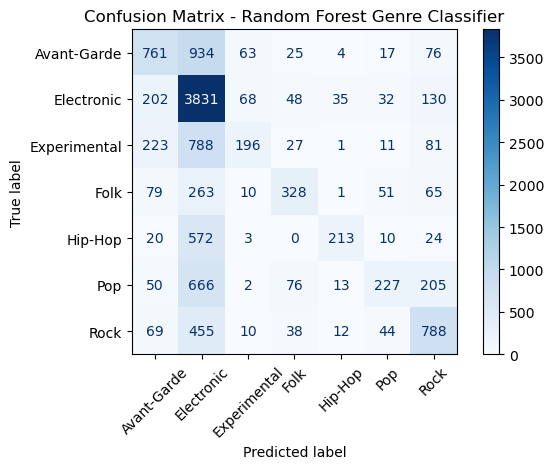

In [5]:
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

# Load dataset
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
file_path = os.path.join(base_dir, "data", "processed", "final.csv")
df = pd.read_csv(file_path)

# Separate features and labels
X = df.drop(columns=['track_id', 'primary_genre'])
y = df['primary_genre']

# Encode genre labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42
)

# Initialize Random Forest with best GridSearchCV parameters
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)
clf.fit(X_train, y_train)

# Predict on test set
y_pred = clf.predict(X_test)

# Decode predictions and true labels back to genre names
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)

# Evaluate performance
print("=== Classification Report ===")
print(classification_report(y_test_labels, y_pred_labels))

# Confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels, labels=label_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(xticks_rotation=45, cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Random Forest Genre Classifier")
plt.tight_layout()
plt.show()

# Save the trained model and assets
save_dir = os.path.join("..", "src", "models")
os.makedirs(save_dir, exist_ok=True)

joblib.dump(clf, os.path.join(save_dir, "rf_model.pkl"))
joblib.dump(label_encoder, os.path.join(save_dir, "rf_label_encoder.pkl"))
np.save(os.path.join(save_dir, "rf_genre_classes.npy"), label_encoder.classes_)
X_test.to_csv(os.path.join(save_dir, "rf_X_test.csv"), index=False)

**XGBoost Model**

=== Classification Report ===
              precision    recall  f1-score   support

 Avant-Garde       0.54      0.46      0.49      1880
  Electronic       0.56      0.81      0.66      4346
Experimental       0.48      0.22      0.31      1327
        Folk       0.57      0.46      0.51       797
     Hip-Hop       0.63      0.38      0.47       842
         Pop       0.47      0.27      0.34      1239
        Rock       0.58      0.60      0.59      1416

    accuracy                           0.55     11847
   macro avg       0.55      0.46      0.48     11847
weighted avg       0.55      0.55      0.53     11847



<Figure size 1000x800 with 0 Axes>

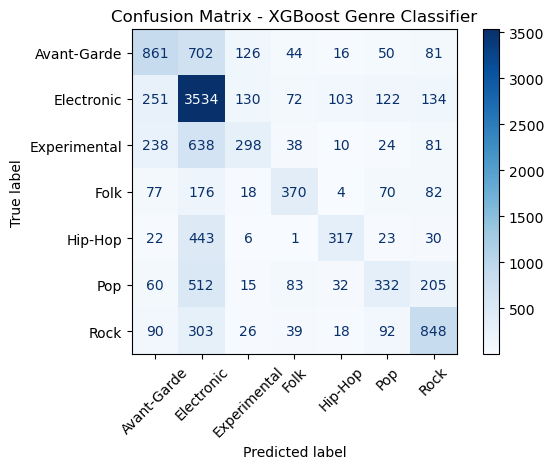

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import os

# Suppress warnings from XGBoost
warnings.filterwarnings("ignore")

# Load dataset
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
file_path = os.path.join(base_dir, "data", "processed", "final.csv")
df = pd.read_csv(file_path)

# Separate features and labels
X = df.drop(columns=['track_id', 'primary_genre'])
y = df['primary_genre']

# Encode genre labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42
)

# Initialize and train the XGBoost classifier
xgb_clf = XGBClassifier(
    objective='multi:softmax',
    num_class=num_classes,
    max_depth=10,              
    learning_rate=0.1,              
    n_estimators=200,                
    subsample=0.8,                   
    colsample_bytree=1,              
    eval_metric='mlogloss',
    random_state=42,
    tree_method='gpu_hist',
    predictor='gpu_predictor'
)
xgb_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_clf.predict(X_test)

# Decode predictions back to genre names for readability
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)

# Print classification report
print("=== Classification Report ===")
print(classification_report(y_test_labels, y_pred_labels))

# Confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels, labels=label_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(xticks_rotation=45, cmap="Blues", values_format='d')
plt.title("Confusion Matrix - XGBoost Genre Classifier")
plt.tight_layout()
plt.show()

# save directory
save_dir = os.path.join("..", "src", "models")
os.makedirs(save_dir, exist_ok=True)
# Save the trained model and labelencoder
joblib.dump(xgb_clf, os.path.join(save_dir, "xgboost_model.pkl"))
joblib.dump(label_encoder, os.path.join(save_dir, "xgb_label_encoder.pkl"))
np.save(os.path.join(save_dir, "xgb_genre_classes.npy"), label_encoder.classes_)
X_test.to_csv(os.path.join(save_dir, "xgb_X_test.csv"), index=False)

**MLP**

Using device: cuda
Epoch [1/300] Loss: 1.3563 | Val Acc: 0.5044
Epoch [2/300] Loss: 1.3469 | Val Acc: 0.5215
Epoch [3/300] Loss: 1.4863 | Val Acc: 0.5265
Epoch [4/300] Loss: 1.1894 | Val Acc: 0.5327
Epoch [5/300] Loss: 1.0136 | Val Acc: 0.5366
Epoch [6/300] Loss: 1.5635 | Val Acc: 0.5373
Epoch [7/300] Loss: 1.3016 | Val Acc: 0.5353
Epoch [8/300] Loss: 1.0797 | Val Acc: 0.5390
Epoch [9/300] Loss: 1.2188 | Val Acc: 0.5487
Epoch [10/300] Loss: 1.4201 | Val Acc: 0.5485
Epoch [11/300] Loss: 1.4964 | Val Acc: 0.5537
Epoch [12/300] Loss: 1.6258 | Val Acc: 0.5561
Epoch [13/300] Loss: 1.0354 | Val Acc: 0.5558
Epoch [14/300] Loss: 1.7490 | Val Acc: 0.5546
Epoch [15/300] Loss: 1.1547 | Val Acc: 0.5543
Epoch [16/300] Loss: 1.0498 | Val Acc: 0.5555
Epoch [17/300] Loss: 1.2472 | Val Acc: 0.5588
Epoch [18/300] Loss: 1.5312 | Val Acc: 0.5585
Epoch [19/300] Loss: 1.2246 | Val Acc: 0.5596
Epoch [20/300] Loss: 1.1656 | Val Acc: 0.5615
Epoch [21/300] Loss: 1.2381 | Val Acc: 0.5593
Epoch [22/300] Loss: 1.5

<Figure size 1200x800 with 0 Axes>

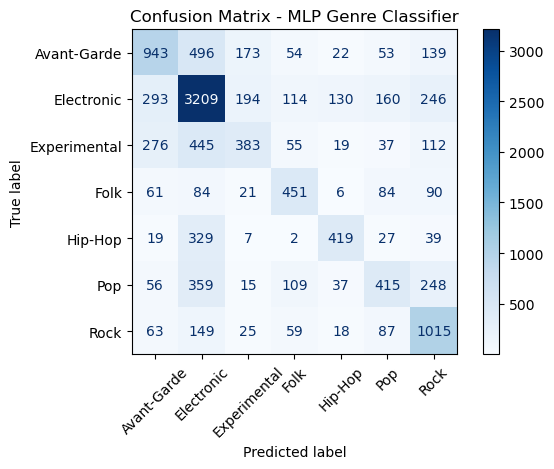

In [12]:
import os
import warnings
import joblib
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Load data
warnings.filterwarnings("ignore", category=UserWarning)
# Load dataset
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
file_path = os.path.join(base_dir, "data", "processed", "final.csv")
df = pd.read_csv(file_path)

# feature selection 
X = df.drop(columns=['track_id', 'primary_genre'])
y = df['primary_genre']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Standardize features 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# train/test split 
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42
)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create dataset and dataLoader
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Detect GPU Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define MLP
class DetailedMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(DetailedMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Linear(128, output_size)
        )

    def forward(self, x):
        return self.net(x)

# Initialize model
input_size = X_train.shape[1]
output_size = len(label_encoder.classes_)
model = DetailedMLP(input_size, output_size).to(device)

# Move test tensors to device
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# Set up training tools
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5, verbose=True)

# train model
best_acc = 0
epochs_without_improve = 0
patience = 30
num_epochs = 300

for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, preds = torch.max(outputs, 1)
        val_acc = accuracy_score(y_test_tensor.cpu().numpy(), preds.cpu().numpy())
        scheduler.step(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {loss.item():.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_model_state = model.state_dict()
        epochs_without_improve = 0
    else:
        epochs_without_improve += 1
        if epochs_without_improve >= patience:
            print("Early stopping.")
            break

# === Final Evaluation ===
model.load_state_dict(best_model_state)

save_dir = os.path.join("..", "src", "models")
os.makedirs(save_dir, exist_ok=True)
# Save model state dict, labelencoder, and standard scaler
torch.save(model.state_dict(), os.path.join(save_dir, "mlp_model.pth"))
joblib.dump(label_encoder, os.path.join(save_dir, "label_encoder.pkl"))
joblib.dump(scaler, os.path.join(save_dir, "scaler.pkl"))
np.save(os.path.join(save_dir, "genre_classes.npy"), label_encoder.classes_)
torch.save(X_test_tensor, os.path.join(save_dir, "X_test_tensor.pt"))

model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, final_preds = torch.max(outputs, 1)

y_pred = final_preds.cpu().numpy()
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_test_labels = label_encoder.inverse_transform(y_test)

# Classification Report
print("\n=== Classification Report ===")
print(classification_report(y_test_labels, y_pred_labels))

# Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=label_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

plt.figure(figsize=(12, 8))
disp.plot(xticks_rotation=45, cmap="Blues", values_format='d')
plt.title("Confusion Matrix - MLP Genre Classifier")
plt.tight_layout()
plt.show()

**Ensemble**


=== Classification Report: Ensemble ===
              precision    recall  f1-score   support

 Avant-Garde       0.57      0.49      0.53      1880
  Electronic       0.61      0.79      0.68      4346
Experimental       0.50      0.24      0.33      1327
        Folk       0.57      0.55      0.56       797
     Hip-Hop       0.66      0.48      0.55       842
         Pop       0.50      0.31      0.39      1239
        Rock       0.55      0.71      0.62      1416

    accuracy                           0.58     11847
   macro avg       0.57      0.51      0.52     11847
weighted avg       0.57      0.58      0.56     11847



<Figure size 1200x800 with 0 Axes>

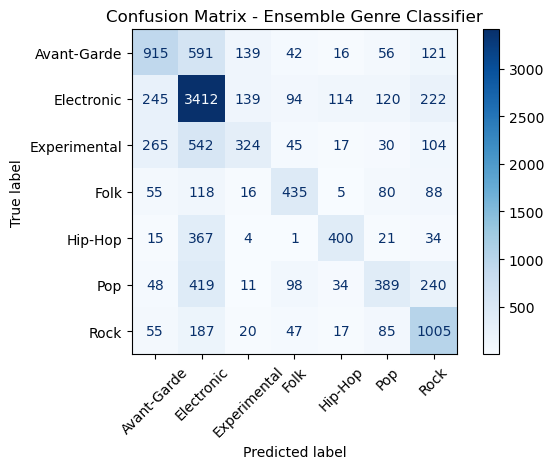

In [15]:
import numpy as np

# === 1. Get Probabilities ===
rf_probs = clf.predict_proba(X_test)            # Random Forest
xgb_probs = xgb_clf.predict_proba(X_test)           # XGBoost
mlp_probs = torch.softmax(model(X_test_tensor), dim=1).detach().cpu().numpy() # MLP (PyTorch)

# === 2. Apply Weights ===
rf_weight = 0.15
xgb_weight = 0.15
mlp_weight = 0.70

# === 3. Weighted Average of Probabilities ===
ensemble_probs = (
    rf_weight * rf_probs +
    xgb_weight * xgb_probs +
    mlp_weight * mlp_probs
)

# === 4. Predict Final Classes ===
ensemble_preds = np.argmax(ensemble_probs, axis=1)
ensemble_pred_labels = label_encoder.inverse_transform(ensemble_preds)

# === 5. Evaluate Ensemble ===
print("\n=== Classification Report: Ensemble ===")
print(classification_report(y_test_labels, ensemble_pred_labels))

# === 6. Confusion Matrix ===
ensemble_cm = confusion_matrix(y_test_labels, ensemble_pred_labels, labels=label_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=ensemble_cm, display_labels=label_encoder.classes_)

plt.figure(figsize=(12, 8))
disp.plot(xticks_rotation=45, cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Ensemble Genre Classifier")
plt.tight_layout()
plt.show()

**Convolutional Neural Network**

Using device: cuda
Epoch [1/100], Loss: 1.5257, Accuracy: 39.36%
Epoch [2/100], Loss: 1.6685, Accuracy: 43.28%
Epoch [3/100], Loss: 1.1567, Accuracy: 44.72%
Epoch [4/100], Loss: 1.6115, Accuracy: 45.34%
Epoch [5/100], Loss: 1.5886, Accuracy: 45.86%
Epoch [6/100], Loss: 1.3203, Accuracy: 46.37%
Epoch [7/100], Loss: 1.0544, Accuracy: 46.94%
Epoch [8/100], Loss: 1.1715, Accuracy: 47.23%
Epoch [9/100], Loss: 1.0056, Accuracy: 47.20%
Epoch [10/100], Loss: 1.5598, Accuracy: 47.36%
Epoch [11/100], Loss: 1.0635, Accuracy: 47.15%
Epoch [12/100], Loss: 1.5429, Accuracy: 47.81%
Epoch [13/100], Loss: 1.6161, Accuracy: 48.02%
Epoch [14/100], Loss: 1.3336, Accuracy: 48.05%
Epoch [15/100], Loss: 1.4127, Accuracy: 48.30%
Epoch [16/100], Loss: 1.2946, Accuracy: 48.32%
Epoch [17/100], Loss: 1.4142, Accuracy: 48.44%
Epoch [18/100], Loss: 1.7187, Accuracy: 48.08%
Epoch [19/100], Loss: 1.5263, Accuracy: 48.58%
Epoch [20/100], Loss: 1.2655, Accuracy: 48.29%
Epoch [21/100], Loss: 1.1554, Accuracy: 48.66%
Epo

<Figure size 1000x800 with 0 Axes>

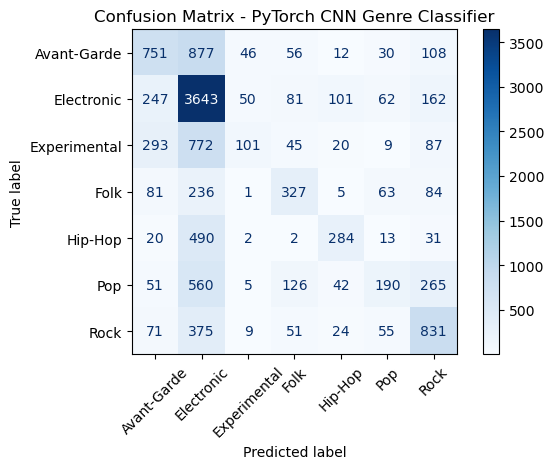

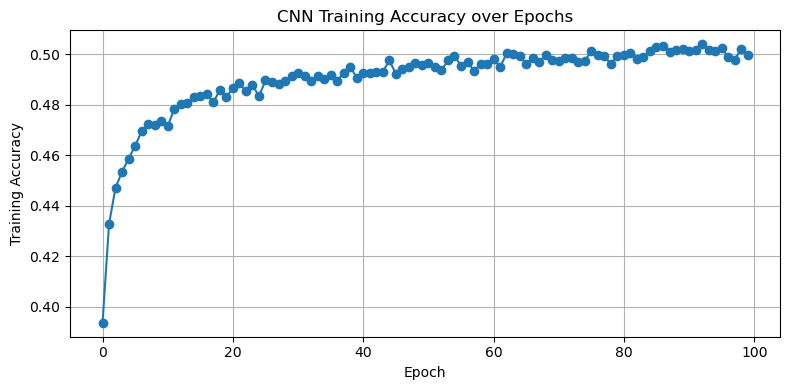

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
file_path = os.path.join(base_dir, "data", "processed", "final.csv")
df = pd.read_csv(file_path)

# Extract features and labels
X = df.drop(columns=['track_id', 'primary_genre'])
y = df['primary_genre']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# Pad features to nearest square size
num_features = X.shape[1]
side_len = int(np.ceil(np.sqrt(num_features)))
padded_features = np.zeros((len(X), side_len * side_len))
padded_features[:, :num_features] = X

# Reshape for CNN: (samples, 1, height, width)
X_reshaped = padded_features.reshape(-1, 1, side_len, side_len)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42
)

# PyTorch Dataset
class GenreDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_data = GenreDataset(X_train, y_train)
test_data = GenreDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# CNN Model
class GenreCNN(nn.Module):
   def __init__(self, num_classes):
      super(GenreCNN, self).__init__()
      self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
      self.pool1 = nn.MaxPool2d(2, 2)
      self.dropout1 = nn.Dropout(0.3)

      self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
      self.pool2 = nn.MaxPool2d(2, 2)
      self.dropout2 = nn.Dropout(0.3)

      flat_size = self._get_flattened_size()
      self.fc1 = nn.Linear(flat_size, 128)
      self.dropout3 = nn.Dropout(0.4)
      self.fc2 = nn.Linear(128, num_classes)

   def _get_flattened_size(self):
      dummy_input = torch.zeros(1, 1, side_len, side_len)
      x = self.pool1(F.relu(self.conv1(dummy_input)))
      x = self.pool2(F.relu(self.conv2(x)))
      return x.numel()

   def forward(self, x):
      x = self.pool1(F.relu(self.conv1(x)))
      x = self.dropout1(x)
      x = self.pool2(F.relu(self.conv2(x)))
      x = self.dropout2(x)
      x = torch.flatten(x, 1)
      x = F.relu(self.fc1(x))
      x = self.dropout3(x)
      x = self.fc2(x)
      return x

# Initialize model
model = GenreCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
train_acc_history = []

for epoch in range(num_epochs):
   model.train()
   correct = 0
   total = 0

   for X_batch, y_batch in train_loader:
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)
      outputs = model(X_batch)
      loss = criterion(outputs, y_batch)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      _, predicted = torch.max(outputs, 1)
      total += y_batch.size(0)
      correct += (predicted == y_batch).sum().item()

   acc = correct / total
   train_acc_history.append(acc)
   print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {acc*100:.2f}%")

# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
   for X_batch, y_batch in test_loader:
      X_batch = X_batch.to(device)
      outputs = model(X_batch)
      _, predicted = torch.max(outputs, 1)
      all_preds.extend(predicted.cpu().numpy())
      all_labels.extend(y_batch.numpy())

# Convert predictions back to labels
y_pred_labels = label_encoder.inverse_transform(all_preds)
y_test_labels = label_encoder.inverse_transform(all_labels)

# Report
print("\n=== CNN Classification Report ===")
print(classification_report(y_test_labels, y_pred_labels))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels, labels=label_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)

plt.figure(figsize=(10, 8))
disp.plot(xticks_rotation=45, cmap="Blues", values_format='d')
plt.title("Confusion Matrix - PyTorch CNN Genre Classifier")
plt.tight_layout()
plt.show()

# Plot Training Accuracy
plt.figure(figsize=(8, 4))
plt.plot(train_acc_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.title("CNN Training Accuracy over Epochs")
plt.grid(True)
plt.tight_layout()
plt.show()